In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator
import seaborn as sns

the idea behind this script is:
    
    1. update prodigal output of target genomes to the format metachip has
    2. merge the updated output to metachip 

### Nov 29th 2022

#### update prodigal

In [2]:
cluster_name = 'unc_12'
dir_target = '/work/projects/archaea_neurodeg/coevolution/hgt_analysis/hgt_genes/uniq'

In [3]:
genomes_in_SC = pd.read_csv('/work/projects/archaea_neurodeg/coevolution/hgt_analysis/hgt_genes/uniq/genomes_in_SCs/genomes_in_'+
                            cluster_name+'.tsv',
                           header=None, names=['genome'])

In [4]:
genomes_in_SC.head()

genome
0  GUT_GENOME017321
1  GUT_GENOME199661
2  GUT_GENOME187666
3  GUT_GENOME283332
4  GUT_GENOME285619

In [5]:
# final = pd.DataFrame(columns = [['genome', 'coordinates', 'protein']])
final = pd.DataFrame()

for i in range(0,len(genomes_in_SC)):
    genome = genomes_in_SC.genome.iloc[i]
    print(genome)
    prodigal = pd.read_csv('/work/projects/archaea_neurodeg/coevolution/hgt_analysis/prodigal/'+genome+'.gff',
                           sep='\t', header=None, index_col=False,
                           names=['genome', 'prodigal', 'cds', 'start', 'end', 'smth', 'strand', 'smth1', 'etc'])
    prodigal = prodigal[['genome', 'start', 'end', 'strand', 'etc']]
    
    prodigal.start = prodigal.start + 1

    m = prodigal['strand'].eq('-')
    prodigal['coordinates'] = (np.where(m, 'complement(', '')
                        +prodigal['start'].astype(str)+'..'+prodigal['end'].astype(str)
                        +np.where(m, ')', '')
                        )

    prodigal['protein_number'] = prodigal['etc'].str.split(';').str[0].str.replace('ID=1', '')

    prodigal['protein'] = prodigal.genome.astype('str') + prodigal.protein_number.astype('str')

    prodigal = prodigal[['genome', 'coordinates', 'protein']]
    
    final = pd.concat([final, prodigal], axis=0)
    

updated_prodigal = final

updated_prodigal.to_csv(dir_target + '/output_prodigal_updated/'+cluster_name+'.tsv', sep='\t', index=False)

GUT_GENOME017321
GUT_GENOME199661
GUT_GENOME187666
GUT_GENOME283332
GUT_GENOME285619


In [7]:
updated_prodigal['SC'] = cluster_name

In [8]:
updated_prodigal

genome                   coordinates  \
0     GUT_GENOME017321.fasta                        3..388   
1     GUT_GENOME017321.fasta                     392..2544   
2     GUT_GENOME017321.fasta                    2638..3125   
3     GUT_GENOME017321.fasta                    3447..5002   
4     GUT_GENOME017321.fasta                    5147..6090   
...                      ...                           ...   
1783  GUT_GENOME283332.fasta  complement(1798420..1800515)   
1784  GUT_GENOME283332.fasta  complement(1800592..1801277)   
1785  GUT_GENOME283332.fasta  complement(1801224..1803052)   
1786  GUT_GENOME283332.fasta  complement(1803074..1803741)   
1787  GUT_GENOME283332.fasta  complement(1803797..1804050)   

                          protein      SC  
0        GUT_GENOME017321.fasta_1  unc_12  
1        GUT_GENOME017321.fasta_2  unc_12  
2        GUT_GENOME017321.fasta_3  unc_12  
3        GUT_GENOME017321.fasta_4  unc_12  
4        GUT_GENOME017321.fasta_5  unc_12  
...                           ...     ...  
1783  GUT_GENOME283332.fasta_1784  unc_12  
1784  GUT_GENOME283332.fasta_1785  unc_12  
1785  GUT_GENOME283332.fasta_1786  unc_12  
1786  GUT_GENOME283332.fasta_1787  unc_12  
1787  GUT_GENOME283332.fasta_1788  unc_12  

[5454 rows x 4 columns]

#### merge to metachip

In [9]:
metachip = pd.read_csv('/work/projects/archaea_neurodeg/coevolution/hgt_analysis/hgt_genes/consistent_genomes_classification_coords.txt',
           sep='\t')

##### this magic here is to account for genomes being either "donors" or "acceptors" of HGT:

In [10]:
Gene1_upd_prodigal = updated_prodigal.rename(columns={'genome':'Gene1_contig',
                                                      'coordinates':'Gene1_coordinate'})
Gene2_upd_prodigal = updated_prodigal.rename(columns={'genome':'Gene2_contig',
                                                      'coordinates':'Gene2_coordinate'})

merge_Gene1 = metachip.merge(Gene1_upd_prodigal, on=['Gene1_contig', 'Gene1_coordinate'])
merge_Gene2 = metachip.merge(Gene2_upd_prodigal, on=['Gene2_contig', 'Gene2_coordinate'])

# pd.concat([merge_Gene1, merge_Gene2], axis=0).to_csv('/work/projects/archaea_neurodeg/coevolution/hgt_analysis/hgt_genes/uniq/decoded_metachip/' 
#                                                      + cluster_name+'.tsv', sep='\t', index=False)

In [11]:
pd.concat([merge_Gene1, merge_Gene2], axis=0)

Empty DataFrame
Columns: [Gene_1, Gene_2, Identity, end_match, full_length_match, direction, Gene1_contig, Gene2_contig, Gene1_coordinate, Gene2_coordinate, protein, SC]
Index: []

# Summarize results

In [2]:
df_u_orig = pd.read_csv('/work/projects/archaea_neurodeg/coevolution/hgt_analysis/hgt_genes/decoded_metachip_all_clusters_uniq.tsv',
           sep='\t')
df_h_orig = pd.read_csv('/work/projects/archaea_neurodeg/coevolution/hgt_analysis/hgt_genes/decoded_metachip_all_clusters_homo.tsv',
           sep='\t')

In [3]:
df_u = df_u_orig.groupby('SC', as_index=False).agg({'protein':'count'})\
.sort_values('protein', ascending=False)\
.rename(columns={'protein':'amount_of_HGTs'})
df_h = df_h_orig.groupby('SC',  as_index=False).agg({'protein':'count'})\
.sort_values('protein', ascending=False)\
.rename(columns={'protein':'amount_of_HGTs'})

In [4]:
df_u.SC = df_u.SC.str.replace('unc_', 'u')

In [5]:
count_u = pd.read_csv('/work/projects/archaea_neurodeg/coevolution/hgt_analysis/hgt_genes/counts_in_SCs_uniq.tsv', 
                      sep='\t', header=None, names=['SC', 'size'])
count_u = count_u.iloc[1:].dropna()

In [6]:
count_h = pd.read_csv('/work/projects/archaea_neurodeg/coevolution/hgt_analysis/hgt_genes/counts_in_SCs_homo.tsv', 
                      sep='\t', header=None, names=['SC', 'size'])
count_h = count_h.iloc[1:].dropna()

In [7]:
df_u = df_u.merge(count_u)
df_h = df_h.merge(count_h)

In [8]:
df_u['relative'] = df_u['amount_of_HGTs']/df_u['size'].astype(int).round(2)
df_h['relative'] = df_h['amount_of_HGTs']/df_h['size'].astype(int).round(2)

In [9]:
df_h.sort_values('relative', ascending=False, inplace=True)
df_u.sort_values('relative', ascending=False, inplace=True)

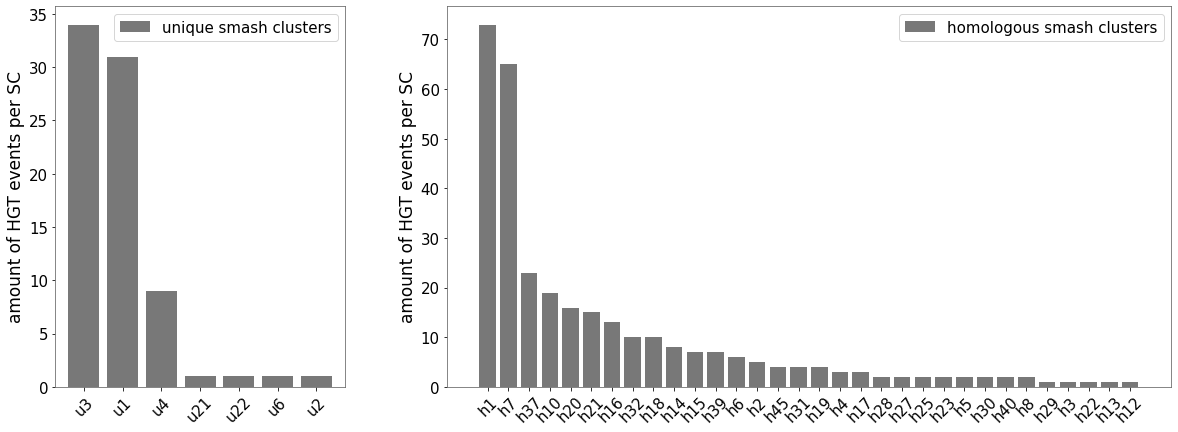

In [22]:
# df_h.sort_values('relative', ascending=False, inplace=True)
# df_u.sort_values('relative', ascending=False, inplace=True)
df_h.sort_values('amount_of_HGTs', ascending=False, inplace=True)
df_u.sort_values('amount_of_HGTs', ascending=False, inplace=True)

labels_u = df_u.SC
labels_h = df_h.SC

fig, axs = plt.subplots(1, 2, sharey=False)
gs = gridspec.GridSpec(1, 2, width_ratios=[2,5])

axs[0] = plt.subplot(gs[0])
axs[1] = plt.subplot(gs[1])

fig.set_figwidth(20)
fig.set_figheight(7)

label_size = 15

plt.rcParams['xtick.labelsize'] = label_size
plt.rcParams['ytick.labelsize'] = label_size

# axs[0].bar(labels_u, df_u.relative, label='unique smash clusters', color = 'dimgray', alpha=0.9)
# axs[0].set_ylabel('amount of HGT events relative to SC size', fontsize = 17)
axs[0].bar(labels_u, df_u.amount_of_HGTs, label='unique smash clusters', color = 'dimgray', alpha=0.9)
axs[0].set_ylabel('amount of HGT events per SC', fontsize = 17)
axs[0].tick_params(axis='x', rotation=45)
axs[0].legend(loc=0, fontsize = 15)
# axs[1].bar(labels_h, df_h.relative, label='homologous smash clusters', color = 'darkgray', alpha=0.9)
# axs[1].set_ylabel('amount of HGT events relative to SC size', fontsize = 17)
axs[1].bar(labels_h, df_h.amount_of_HGTs, label='homologous smash clusters', color = 'dimgray', alpha=0.9)
axs[1].set_ylabel('amount of HGT events per SC', fontsize = 17)
axs[1].tick_params(axis='x', rotation=45)
axs[1].legend(loc=0, fontsize = 15)
# axs[1].yaxis.grid('major', linestyle='--', linewidth=0.5)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.25)

plt.setp(axs[0].spines.values(), color='dimgray')
plt.setp(axs[1].spines.values(), color='dimgray')

# plt.savefig('/work/projects/archaea_neurodeg/coevolution/hgt_analysis/pics/SC_genes_in_HGT_relative_to_size.png', 
#             format='png', dpi=600, bbox_inches='tight')
# plt.savefig('/work/projects/archaea_neurodeg/coevolution/hgt_analysis/pics/SC_genes_in_HGT_relative_to_size.tiff', 
#             format='tiff', dpi=600, bbox_inches='tight')
plt.savefig('/work/projects/archaea_neurodeg/coevolution/hgt_analysis/pics/SC_genes_in_HGT_gray.png', 
            format='png', dpi=600, bbox_inches='tight')
plt.savefig('/work/projects/archaea_neurodeg/coevolution/hgt_analysis/pics/SC_genes_in_HGT_gray.tiff', 
            format='tiff', dpi=600, bbox_inches='tight')